# Blood Glucose Control - EDA

**Name:** Gavin Katz



### Import Data

There are multiple data sets each corresponding to a person with diabetes. Please load the files into a single data set while retaining the ability to distinguish between the PWD.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_path_bgl_1 = '/content/bgl_1.csv'
file_path_bgl_2 = '/content/bgl_2.csv'

# Load the CSV files into dataframes
bgl_1 = pd.read_csv(file_path_bgl_1)
bgl_2 = pd.read_csv(file_path_bgl_2)

bgl_1.head(), bgl_2.head()

(                               date  sender_id    bgl  bgl_date_millis text  \
 0  2024-05-01 00:00:27.029000-05:00        NaN  114.0              NaN  NaN   
 1  2024-05-01 00:05:27.183000-05:00        NaN  117.0              NaN  NaN   
 2  2024-05-01 00:10:26.949000-05:00        NaN  113.0              NaN  NaN   
 3  2024-05-01 00:15:27.180000-05:00        NaN  112.0              NaN  NaN   
 4  2024-05-01 00:20:27.021000-05:00        NaN  113.0              NaN  NaN   
 
   template msg_type affects_fob affects_iob  dose_units  food_g  \
 0      NaN      NaN         NaN         NaN         NaN     NaN   
 1      NaN      NaN         NaN         NaN         NaN     NaN   
 2      NaN      NaN         NaN         NaN         NaN     NaN   
 3      NaN      NaN         NaN         NaN         NaN     NaN   
 4      NaN      NaN         NaN         NaN         NaN     NaN   
 
    food_glycemic_index dose_automatic  fp_bgl  message_basal_change  \
 0                  NaN            N

### Data Cleaning


In [41]:
# Convert the date column to datetime and inspect missing or invalid data
bgl_1['date'] = pd.to_datetime(bgl_1['date'], errors='coerce')
bgl_2['date'] = pd.to_datetime(bgl_2['date'], errors='coerce')

# Remove rows with NaN or invalid blood glucose levels (i.e. negative or NaN values in bgl)
bgl_1_clean = bgl_1.dropna(subset=['bgl']).loc[bgl_1['bgl'] > 0].copy()
bgl_2_clean = bgl_2.dropna(subset=['bgl']).loc[bgl_2['bgl'] > 0].copy()

# Drop any irrelevant columns
columns_to_drop = ['sender_id', 'bgl_date_millis', 'text', 'template', 'msg_type',
                   'affects_fob', 'affects_iob', 'dose_units', 'food_g', 'food_glycemic_index',
                   'dose_automatic', 'fp_bgl', 'message_basal_change', '__typename', 'trend']

bgl_1_clean.drop(columns=columns_to_drop, inplace=True)
bgl_2_clean.drop(columns=columns_to_drop, inplace=True)

# Combine the datasets
combined_bgl = pd.concat([bgl_1_clean, bgl_2_clean]).reset_index(drop=True)

# Define some more useful columns
combined_bgl['date'] = pd.to_datetime(combined_bgl['date'], utc=True)
combined_bgl['hour'] = combined_bgl['date'].dt.hour
combined_bgl['day_of_week'] = combined_bgl['date'].dt.dayofweek
combined_bgl['week'] = combined_bgl['date'].dt.isocalendar().week
combined_bgl['day'] = combined_bgl['date'].dt.date


# Check for any remaining invalid data and verify the cleanup
combined_bgl.info(), combined_bgl.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59587 entries, 0 to 59586
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   date         39080 non-null  datetime64[ns, UTC]
 1   bgl          59587 non-null  float64            
 2   hour         39080 non-null  float64            
 3   day_of_week  39080 non-null  float64            
 4   week         39080 non-null  UInt32             
 5   day          39080 non-null  object             
dtypes: UInt32(1), datetime64[ns, UTC](1), float64(3), object(1)
memory usage: 2.6+ MB


(None,
                 bgl          hour   day_of_week       week
 count  59587.000000  39080.000000  39080.000000    39080.0
 mean     125.929498     11.486540      2.880143  25.327917
 std       35.488226      7.035363      1.959143   3.719876
 min       39.000000      0.000000      0.000000       18.0
 25%      101.000000      5.000000      1.000000       22.0
 50%      122.000000     12.000000      3.000000       26.0
 75%      146.000000     18.000000      5.000000       29.0
 max      292.000000     23.000000      6.000000       31.0)

### Two Data Visualizations

Create at least two visualizations that are of interest to you. They can be things that would be useful information for a PWD to know, or they could be useful for informing future modeling work. If you aren't sure what to visualize try recreating common diabetes data visualizations that you can find on the internet.

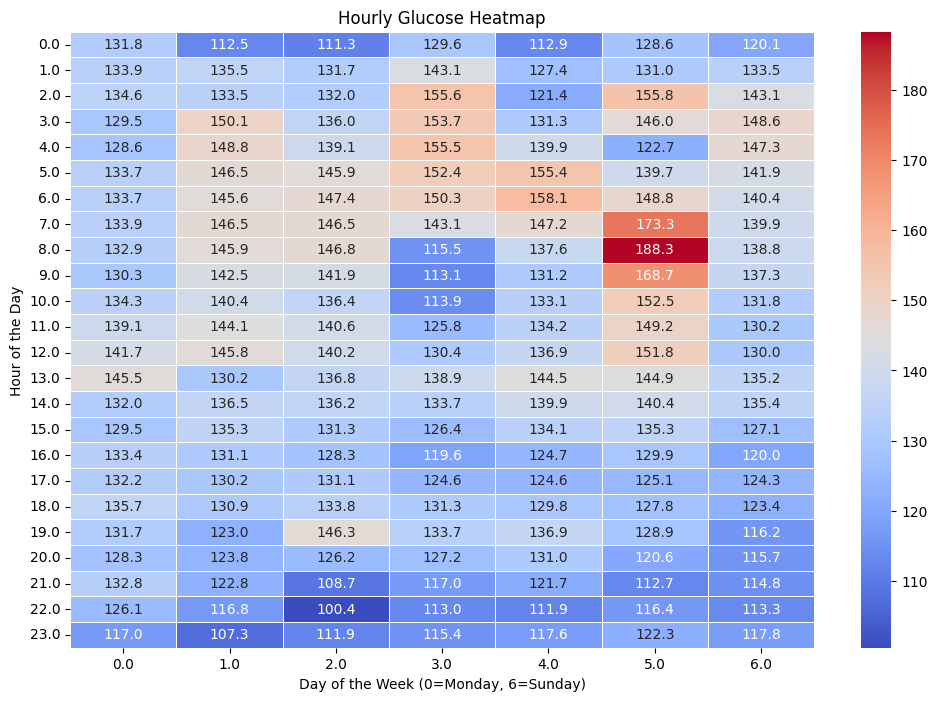

In [42]:
# Plot 1: Heatmap of Blood Glucose by Hour and Day of the Week
plt.figure(figsize=(12, 8))
heatmap_data = combined_bgl.pivot_table(index='hour', columns='day_of_week', values='bgl', aggfunc='mean')
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.1f', linewidths=.5)
plt.title('Hourly Glucose Heatmap')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Hour of the Day')
plt.show()

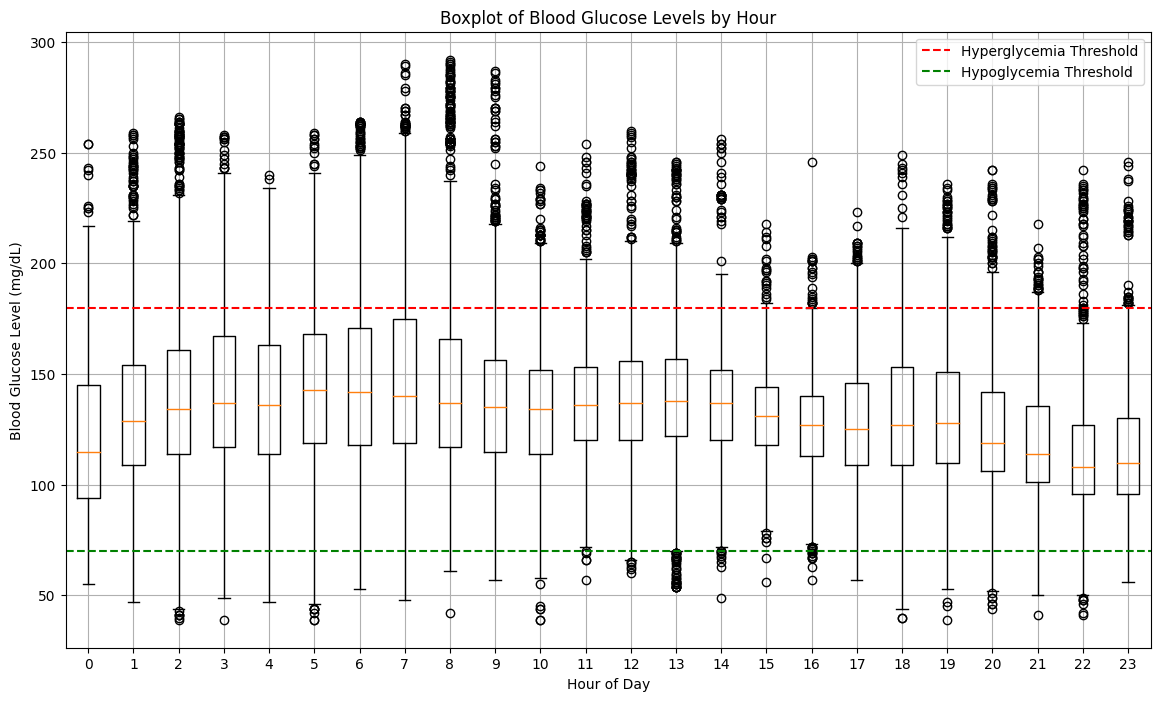

In [43]:
# Plot 2: Boxplot of Blood Glucose Levels by Hour
plt.figure(figsize=(14, 8))
plt.boxplot([combined_bgl[combined_bgl['hour'] == hour]['bgl'] for hour in range(24)], positions=range(24))
plt.title('Boxplot of Blood Glucose Levels by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Blood Glucose Level (mg/dL)')
plt.grid(True)
plt.axhline(y=180, color='red', linestyle='--', label='Hyperglycemia Threshold')
plt.axhline(y=70, color='green', linestyle='--', label='Hypoglycemia Threshold')
plt.legend()
plt.show()

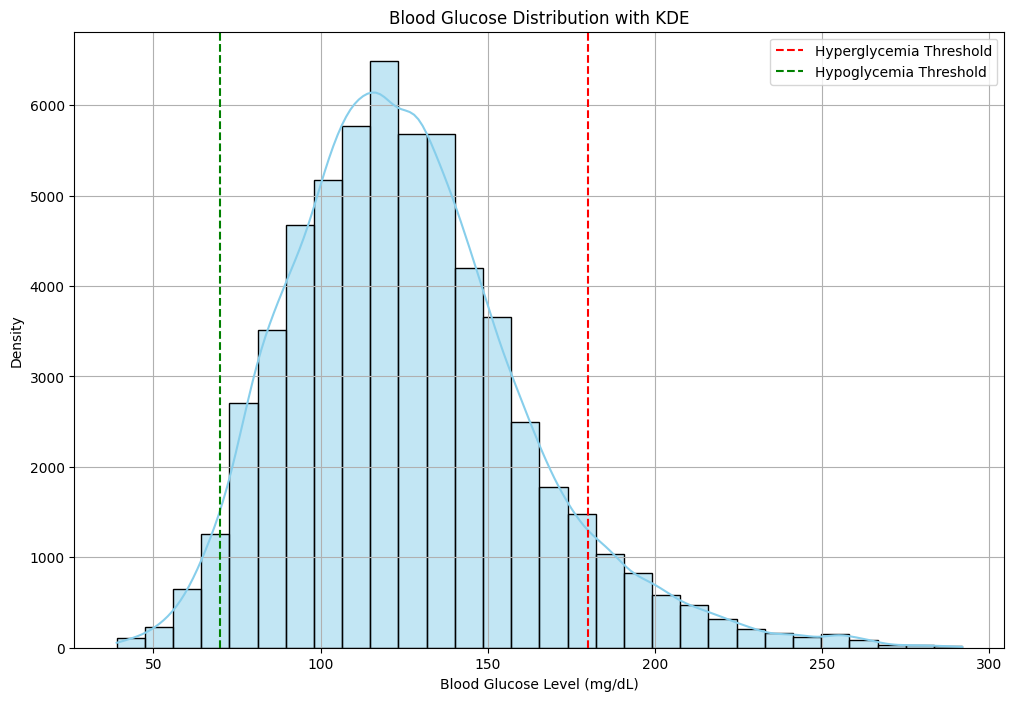

In [44]:
# Plot 3: Blood Glucose Distribution with KDE
plt.figure(figsize=(12, 8))
sns.histplot(combined_bgl['bgl'], kde=True, bins=30, color='skyblue', edgecolor='black')
plt.title('Blood Glucose Distribution with KDE')
plt.xlabel('Blood Glucose Level (mg/dL)')
plt.ylabel('Density')
plt.grid(True)
plt.axvline(x=180, color='red', linestyle='--', label='Hyperglycemia Threshold')
plt.axvline(x=70, color='green', linestyle='--', label='Hypoglycemia Threshold')
plt.legend()
plt.show()

### Ask a question(s) about the data and/or diabetes!
When creating the visualizations you probably had some questions about managing T1D. Ask some questions that might interest you and our diabetes experts will do their best to answer them for you! *Consider this an AMAA about diabetes.*

1. How do meal timing and macronutrient composition (carbs vs. protein/fat) impact insulin dosing and post-meal glucose spikes in T1D management?
2. What are the most common factors that cause insulin sensitivity to vary throughout the day, and how can people with T1D adjust their insulin dosing accordingly?

### Final Task

Thanks for showing interest in our project! We plan to incorporate the best/most interesting visualizations into a substack post in the future.

Please remember to create a pull request with your updated template, don't forget to rename the file to something that we can identify you with, e.g: `eda_[your_name].ipynb`